In [91]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
import statsmodels.formula.api as sm
import seaborn as sb
dataPath = 'C:\\Users\\austi\OneDrive - Imperial College London\ACG\ABS Loan Data'
os.chdir(dataPath)

In [44]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [62]:
dataTapesList = os.listdir(dataPath)[0:-1]
colList = ['assetNumber', 'reportingPeriodBeginningDate', 'originationDate', 'originalLoanTerm', 'originalInterestRatePercentage', 'subvented',
          'vehicleManufacturerName', 'vehicleModelName', 'vehicleNewUsedCode', 'vehicleModelYear', 'vehicleTypeCode', 'obligorCreditScore',
           'obligorIncomeVerificationLevelCode', 'obligorEmploymentVerificationCode', 'coObligorIndicator', 'paymentToIncomePercentage',
           'obligorGeographicLocation', 'reportingPeriodBeginningLoanBalanceAmount', 'reportingPeriodActualEndBalanceAmount', 'zeroBalanceEffectiveDate', 'zeroBalanceCode', 'currentDelinquencyStatus']

In [63]:
data = pd.read_csv(dataTapesList[0], usecols=colList)

C:\Users\austi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
startingNumberOfLoans = len(data.index)
print('Number of Loans at the start of the deal: ', startingNumberOfLoans)
data.head()

Number of Loans at the start of the deal:  80636


,assetNumber,reportingPeriodBeginningDate,originationDate,originalLoanTerm,originalInterestRatePercentage,subvented,vehicleManufacturerName,vehicleModelName,vehicleNewUsedCode,vehicleModelYear,vehicleTypeCode,obligorCreditScore,obligorIncomeVerificationLevelCode,obligorEmploymentVerificationCode,coObligorIndicator,paymentToIncomePercentage,obligorGeographicLocation,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount,zeroBalanceEffectiveDate,zeroBalanceCode,currentDelinquencyStatus
0,"=""6345520""",06-01-2017,10/2013,72,0.1932,1,DODGE TRUCK,Journey-4 Cyl.,1,2013,3,592,2,2,False,0.139531,MI,16672.09,16258.26,-,-,0
1,"=""6345701""",06-01-2017,11/2013,72,0.2499,0,FORD,Focus-4 Cyl.,2,2009,1,570,2,2,True,0.138530,SC,12151.05,12107.82,-,-,0
2,"=""6345822""",06-01-2017,11/2013,60,0.2100,0,GMC,Yukon,2,2003,3,574,2,2,True,0.077623,CO,10124.13,9963.16,-,-,0
3,"=""6346124""",06-01-2017,10/2013,60,0.2100,0,TOYOTA,Tundra Double Cab-V6,2,2007,2,629,3,2,True,0.114215,OK,7619.25,7277.06,-,-,8
4,"=""1006458""",06-01-2017,05/2012,72,0.2499,0,Jeep,Grand Cherokee,2,2006,3,-,3,3,False,0.154751,NV,10385.66,9641.64,-,-,0


In [65]:
terminatedTrackingColumns = ['assetNumber','reportingPeriodBeginningDate', 'originationDate', 'originalLoanTerm',
                             'zeroBalanceEffectiveDate', 'zeroBalanceCode', 'currentDelinquencyStatus']
dfTerminated = pd.DataFrame()
for i in range(0, len(dataTapesList)):
    data = pd.read_csv(dataTapesList[i], usecols=colList)
    data['zeroBalanceCode'] = pd.to_numeric(data['zeroBalanceCode'], errors='coerce').fillna(0)
    data = data[data.zeroBalanceCode.isin([1, 4])]
    #print(data.head())
    dfTerminated = dfTerminated.append(data)

C:\Users\austi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [66]:
dfTerminated.drop_duplicates(subset='assetNumber', keep='first', inplace=True)

In [67]:
numberOfDefaults = dfTerminated['zeroBalanceCode'].value_counts().tolist()[0]
print('Total Number of Loans: ', startingNumberOfLoans)
print('Total Number of Defaults: ', numberOfDefaults)
#print(dfTerminated['zeroBalanceCode'].value_counts())
print('Loan Defualt Percentage: ', numberOfDefaults/startingNumberOfLoans)

Total Number of Loans:  80636
Total Number of Defaults:  9264
Loan Defualt Percentage:  0.11488665112356763


In [68]:
nonPerformingAssetNumberList = dfTerminated['assetNumber'].tolist()

In [69]:
startingPointData = pd.read_csv(dataTapesList[0], usecols=colList)
startingPointData = startingPointData[startingPointData.assetNumber.isin(nonPerformingAssetNumberList)][['assetNumber', 'reportingPeriodBeginningLoanBalanceAmount']]
startingPointData.rename(columns={'reportingPeriodBeginningLoanBalanceAmount': 'startingLoanBalance'}, inplace=True)

C:\Users\austi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [72]:
dfTerminated = pd.merge(dfTerminated, startingPointData, how='inner', on='assetNumber')

In [77]:
dfTerminated['obligorCreditScore'] = pd.to_numeric(dfTerminated['obligorCreditScore'], errors='coerce').fillna(0)

In [150]:
cleanedData = dfTerminated.drop(['assetNumber', 'reportingPeriodBeginningDate', 'originationDate', 'vehicleManufacturerName', 'subvented', 'originalLoanTerm', 
                                 'vehicleModelName', 'vehicleNewUsedCode', 'obligorIncomeVerificationLevelCode','obligorGeographicLocation', 'coObligorIndicator',
                                 'zeroBalanceEffectiveDate', 'currentDelinquencyStatus',
                                 'reportingPeriodActualEndBalanceAmount', 'startingLoanBalance', 'obligorEmploymentVerificationCode'], axis=1)

In [151]:
for i in list(cleanedData.columns):
    cleanedData[i] = pd.to_numeric(cleanedData[i], errors='coerce')
cleanedData['zeroBalanceCode'].replace(to_replace={4:1, 1:0}, inplace=True)

In [152]:
null_columns=cleanedData.columns[cleanedData.isnull().any()]
cleanedData[null_columns].isnull().sum()

Series([], dtype: float64)

In [157]:
cleanedData.head()

,originalInterestRatePercentage,vehicleModelYear,vehicleTypeCode,obligorCreditScore,paymentToIncomePercentage,reportingPeriodBeginningLoanBalanceAmount,zeroBalanceCode
0,0.2100,2008,1,0.0,0.076434,8776.39,0.0
1,0.2400,2010,1,548.0,0.125043,4739.21,0.0
2,0.2499,2005,1,470.0,0.143080,4143.22,0.0
3,0.2410,2005,2,518.0,0.147815,2384.08,0.0
4,0.2499,2009,1,0.0,0.140553,4109.14,0.0


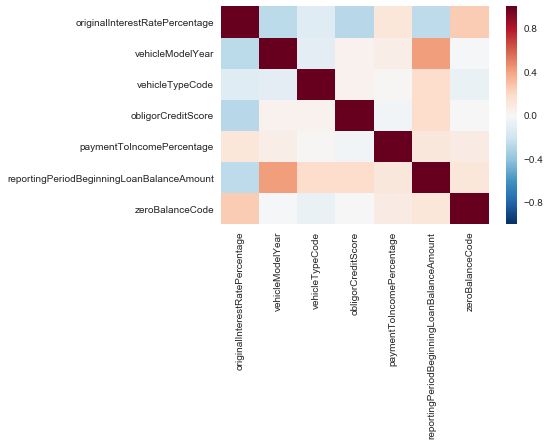

In [153]:
sb.heatmap(cleanedData.corr())

In [154]:
X = list(cleanedData.columns)
X = X[:-1]
X = cleanedData[X]

In [155]:
y = cleanedData['zeroBalanceCode']

In [156]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.629703
         Iterations 6
                                      Results: Logit
Model:                       Logit                    Pseudo R-squared:         0.088     
Dependent Variable:          zeroBalanceCode          AIC:                      21862.7111
Date:                        2018-09-14 18:21         BIC:                      21909.2792
No. Observations:            17350                    Log-Likelihood:           -10925.   
Df Model:                    5                        LL-Null:                  -11986.   
Df Residuals:                17344                    LLR p-value:              0.0000    
Converged:                   1.0000                   Scale:                    1.0000    
No. Iterations:              6.0000                                                       
------------------------------------------------------------------------------------------
                          